<a href="https://colab.research.google.com/github/patrickabadi/python-pytorch-notebooks/blob/main/multiple_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Linear Regression on a multi-variate dataset

- Numpy
- Sci-kit Learn
- Pytorch

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes

dataset = load_diabetes()
print(dataset.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [2]:
# split the data
X = dataset['data']
y = dataset['target']

X.shape, X.dtype, y.shape, y.dtype

((442, 10), dtype('float64'), (442,), dtype('float64'))

In [3]:
from sklearn.model_selection import train_test_split
# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((353, 10), (353,), (89, 10), (89,))

In [4]:
X_train_dt = pd.DataFrame(X_train, columns=dataset['feature_names'] )
X_train_dt.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,-0.041840,-0.044642,0.041218,-0.026328,-0.031840,-0.030437,-0.036038,0.002943,0.033654,-0.017646
1,0.009016,-0.044642,0.045529,0.028758,0.012191,-0.013840,0.026550,-0.039493,0.046133,0.036201
2,0.045341,0.050680,-0.008362,-0.033213,-0.007073,0.001191,-0.039719,0.034309,0.029935,0.027917
3,0.012648,-0.044642,0.015350,-0.033213,0.041086,0.032193,-0.002903,-0.002592,0.045067,-0.067351
4,-0.099961,-0.044642,-0.023451,-0.064199,-0.057983,-0.060186,0.011824,-0.039493,-0.018114,-0.050783


## Linear Regression using Numpy


In [12]:
X_train_numpy = X_train.copy()
X_train_numpy = np.c_[X_train_numpy, np.ones(X_train_numpy.shape[0])] # add bias term

beta = np.linalg.lstsq(X_train_numpy, y_train, rcond=None)[0]
print(beta, beta.shape)


[   4.54589658 -241.12294879  500.54279571  324.68862363 -751.68694211
  460.57066754   83.26892134  171.72286386  703.22844594   51.69857629
  150.5877848 ] (11,)


## Linear Regression using SciKit Learn

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MSE on test {:.3f}".format(mean_squared_error(y_pred, y_test)))
print(f"Intercept: {model.intercept_}, Coefficients: {model.coef_}")

MSE on test 2572.322
Intercept: 150.58778479536784, Coefficients: [   4.54589658 -241.12294879  500.54279571  324.68862363 -751.68694211
  460.57066754   83.26892134  171.72286386  703.22844594   51.69857629]


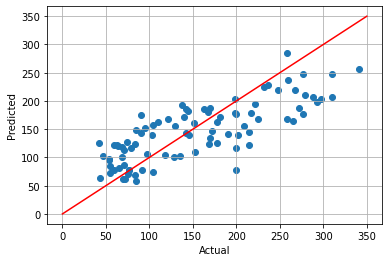

In [11]:
# plot the regression line
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.plot([0,350], [0,350], 'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid()

##Linear Regression with Pytorch

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

class LinearRegressionNN(nn.Module):
  def __init__(self, in_columns: int):
    super().__init__()
    self.linear = nn.Linear(in_features=in_columns, out_features=1, dtype = torch.float64)

  def forward(self, x):
    out = self.linear(x)
    return out;

columns = X_train.shape[1]

# create model, loss function, and optimizer
model = LinearRegressionNN(in_columns=columns).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

NUM_EPOCHS = 10000

model.train()

inputs = torch.from_numpy(X_train).to(device)
targets = torch.from_numpy(y_train).unsqueeze(1).to(device)

print(f"inputs shape: {inputs.shape}, dtype: {inputs.dtype}")

for epoch in tqdm(range(NUM_EPOCHS)):
  y_pred = model(inputs)

  loss = loss_fn(y_pred, targets)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  if epoch % 1000 == 0:
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss.item():.4f}")

# final params
with torch.inference_mode():
  W_val = model.cpu().linear.weight.numpy()
  b_val = model.cpu().linear.bias.numpy()

print(f"Weight: {W_val}, Bias: {b_val}")


inputs shape: torch.Size([353, 10]), dtype: torch.float64


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 1/10000, Loss: 28821.1069
Epoch 1001/10000, Loss: 6163.7187
Epoch 2001/10000, Loss: 5681.7346
Epoch 3001/10000, Loss: 5606.4228
Epoch 4001/10000, Loss: 5540.6334
Epoch 5001/10000, Loss: 5477.0499
Epoch 6001/10000, Loss: 5415.4689
Epoch 7001/10000, Loss: 5355.8192
Epoch 8001/10000, Loss: 5298.0347
Epoch 9001/10000, Loss: 5242.0513
Weight: [[ 11.72253217   1.52185882  39.02922181  29.41400078  13.26968651
   10.86116109 -26.96337088  28.25791473  37.74763879  24.82978314]], Bias: [151.51845774]


In [28]:
# now predict with our test values
model.eval()

input_tests = torch.from_numpy(X_test).to(device)

with torch.inference_mode():
  y_test_pred = model(input_tests).flatten()

print(y_test_pred, y_test)

tensor([153.1086, 151.3819, 146.5644, 153.4969, 160.8767, 154.1083, 155.3482,
        155.1883, 153.7982, 143.3188, 148.7251, 166.6496, 145.1506, 144.5060,
        154.8580, 147.0319, 147.2711, 156.6626, 150.7707, 147.2000, 152.9734,
        163.2771, 154.4320, 157.7972, 158.4486, 153.2301, 163.3044, 140.9756,
        149.0433, 147.0086, 153.3020, 144.4843, 146.6629, 150.3570, 147.6016,
        165.6948, 156.7817, 158.5404, 141.5429, 141.4444, 146.4657, 145.2770,
        139.2620, 153.7316, 141.4649, 164.8985, 153.4288, 142.4208, 154.8022,
        156.2976, 161.3687, 154.3831, 147.1872, 141.5821, 142.2335, 148.6789,
        149.0330, 152.1209, 143.8153, 140.3821, 145.8818, 139.2574, 146.9731,
        156.6710, 158.9841, 158.4768, 160.1259, 158.4889, 150.9174, 139.2920,
        147.3945, 147.0839, 139.0674, 143.1761, 147.4757, 146.5893, 141.2019,
        150.5863, 157.7470, 157.5040, 141.1866, 152.6818, 147.8258, 164.0686,
        146.0690, 153.3796, 149.3824, 137.5127, 149.6190], devic